In [24]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
GLIOMA_DIR = "./data/training/glioma/"
MENIN_DIR = "./data/training/meningioma/"
NOTUMOR_DIR = "./data/training/notumor/"
PITUITARY_DIR = "./data/training/pituitary/"

GLimages = os.listdir(GLIOMA_DIR)
MEimages = os.listdir(MENIN_DIR)
NOimages = os.listdir(NOTUMOR_DIR)
PIimages = os.listdir(PITUITARY_DIR)

In [3]:
def show_samples(images, image_path, plot_text):
    sample = random.sample(images, 3)
    fig, ax = plt.subplots(1, 3, figsize=(25, 9))

    for i in range(3):
        img = cv2.imread(image_path + sample[i])
        img = cv2.resize(img, (224, 224))
        ax[i].imshow(img)
        ax[i].axis('off')
    fig.suptitle(plot_text, fontsize=20)
    plt.show()

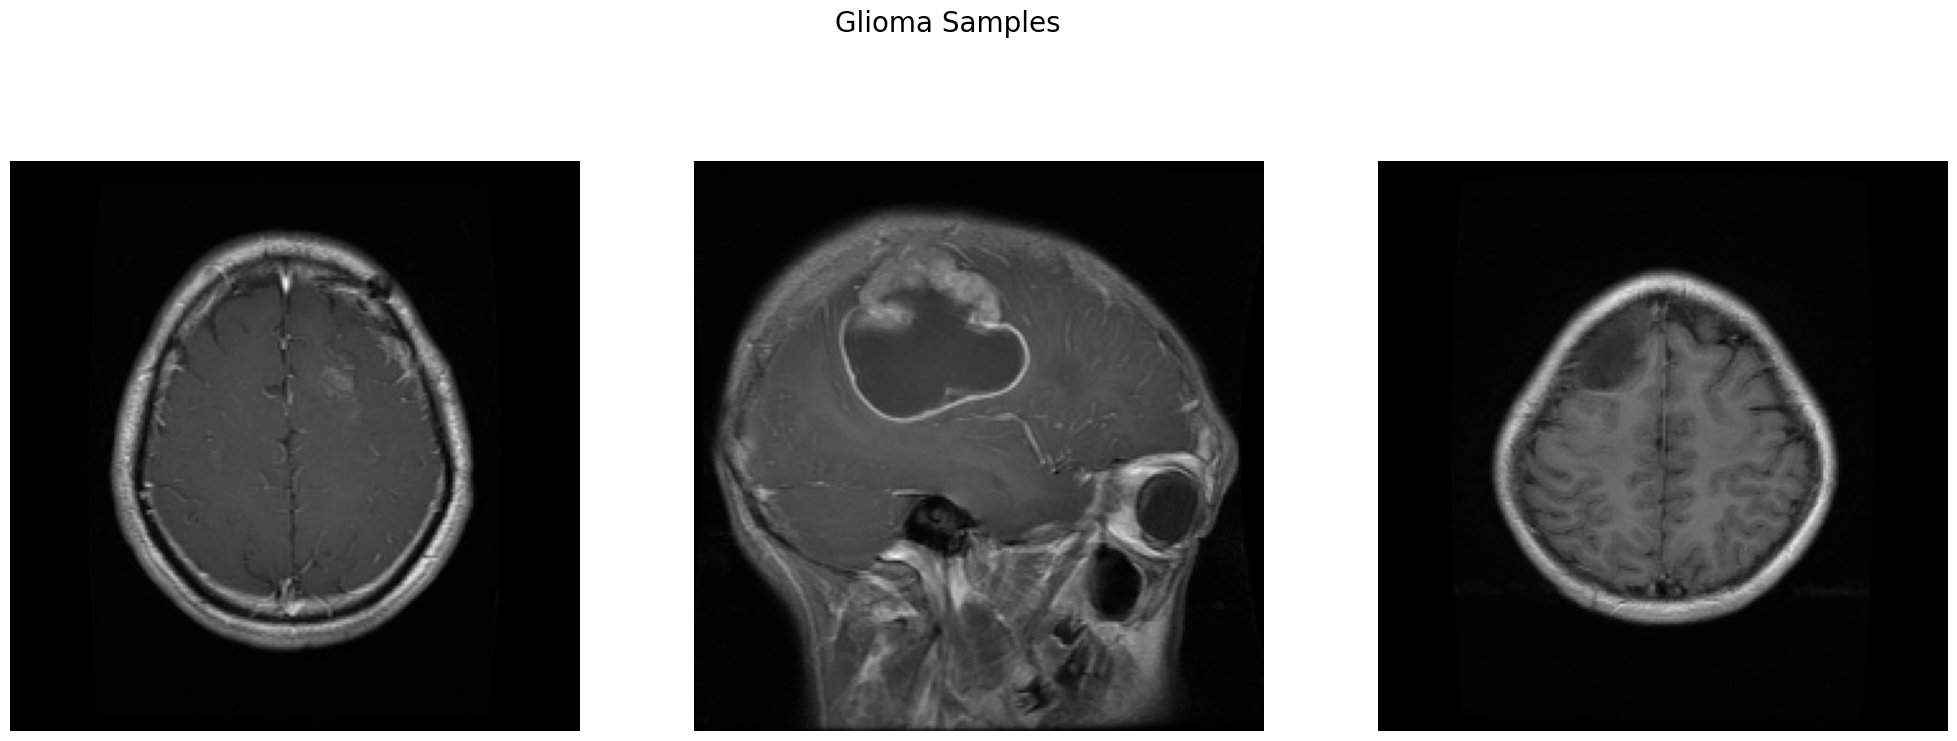

In [33]:
show_samples(GLimages, GLIOMA_DIR, 'Glioma Samples')

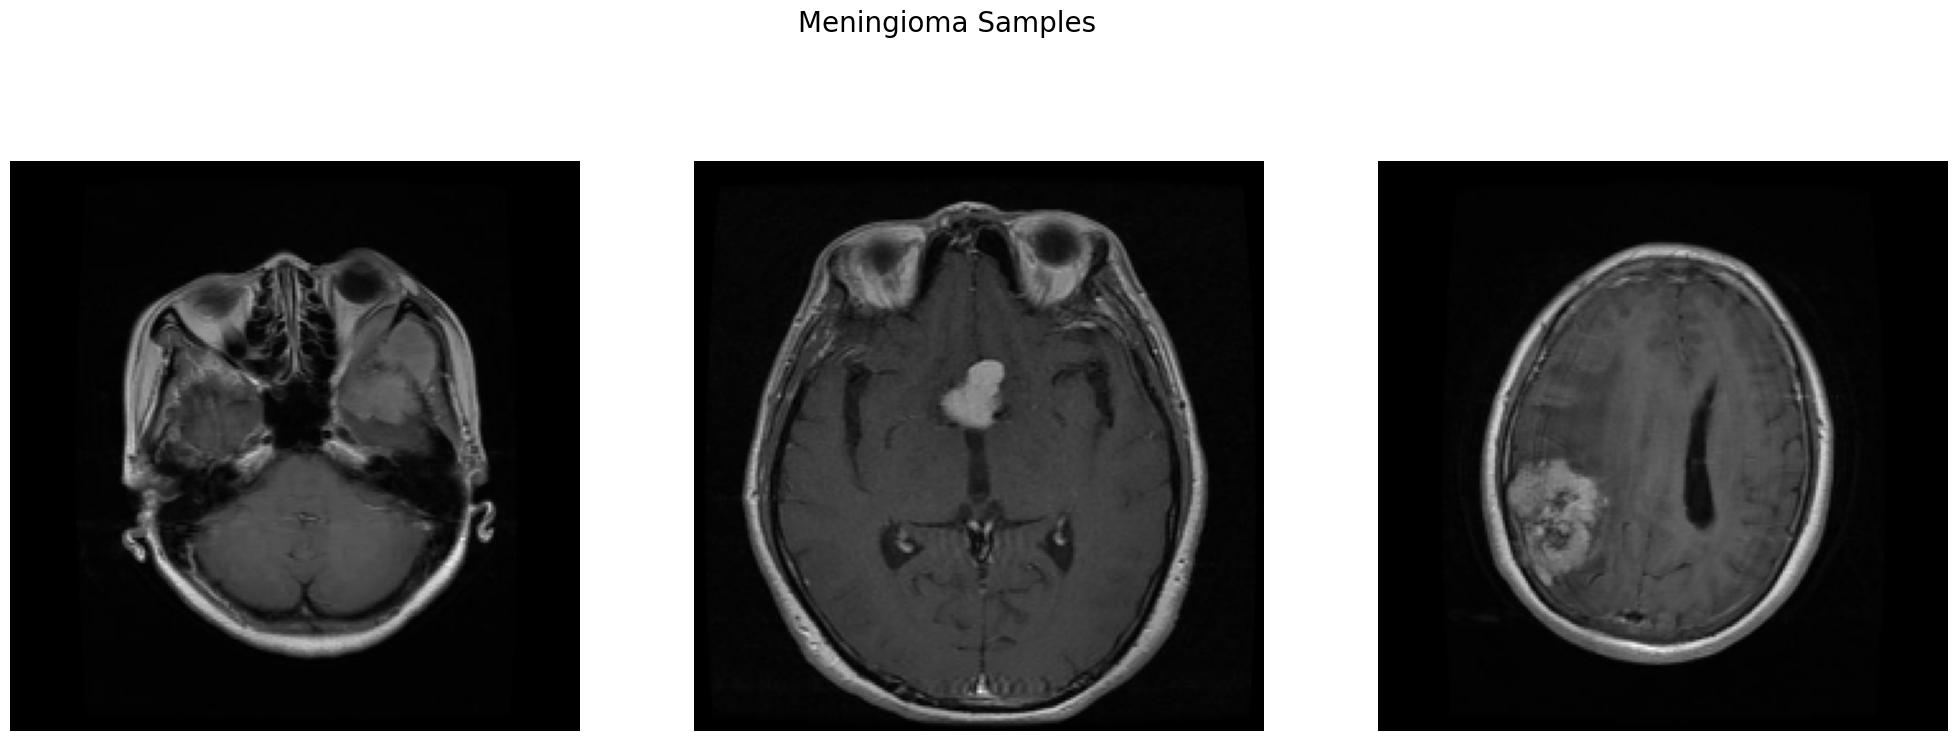

In [34]:
show_samples(MEimages, MENIN_DIR, 'Meningioma Samples')

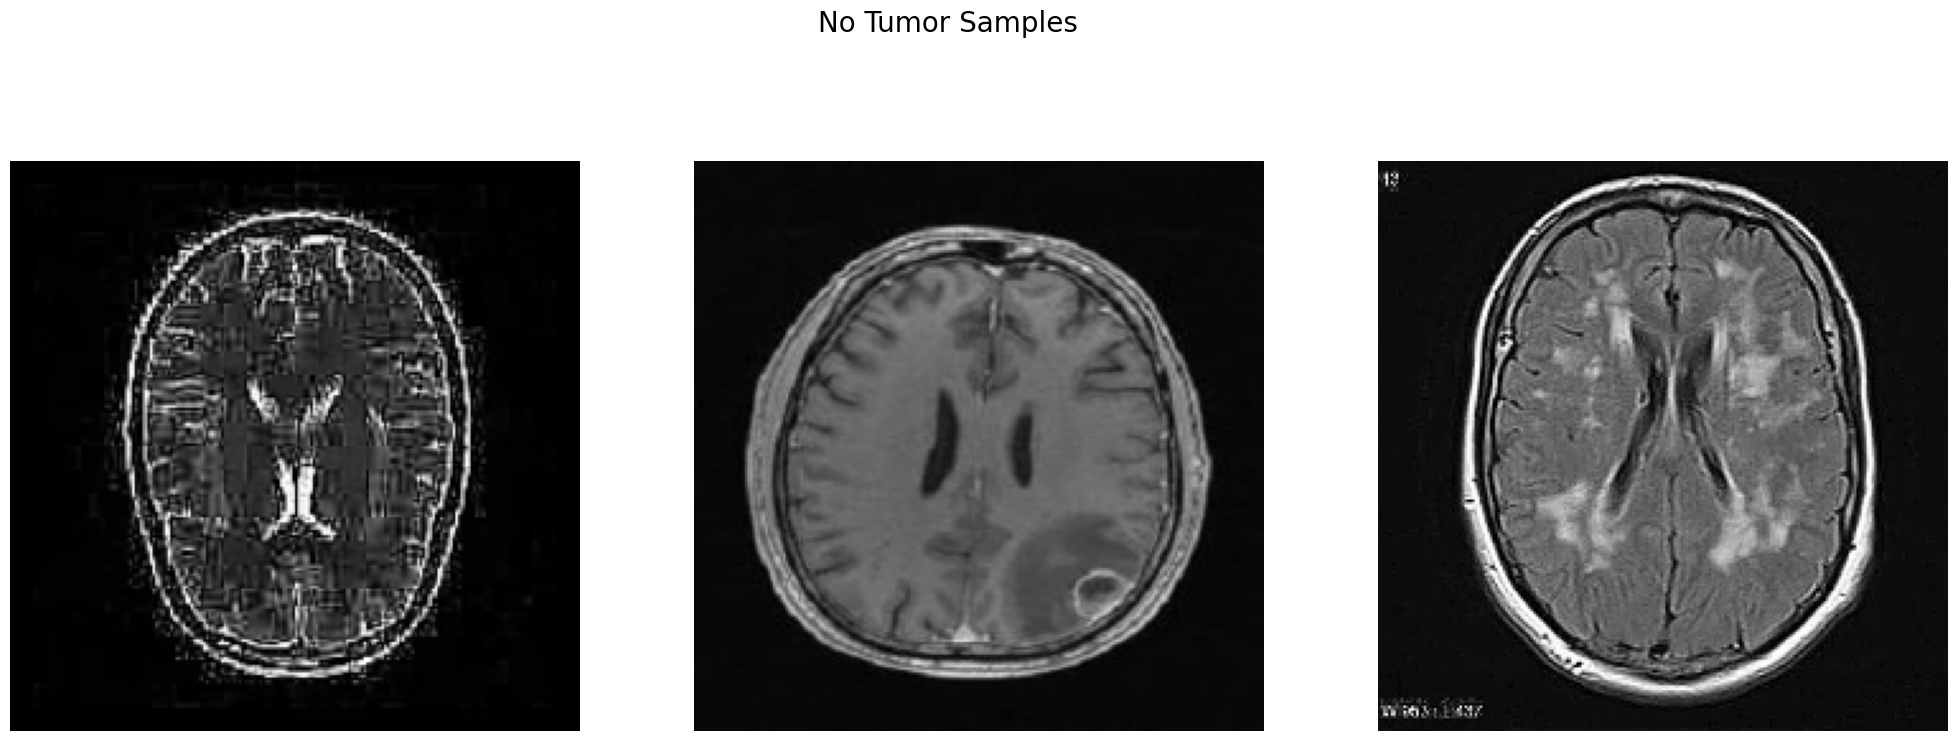

In [35]:
show_samples(NOimages, NOTUMOR_DIR, 'No Tumor Samples')

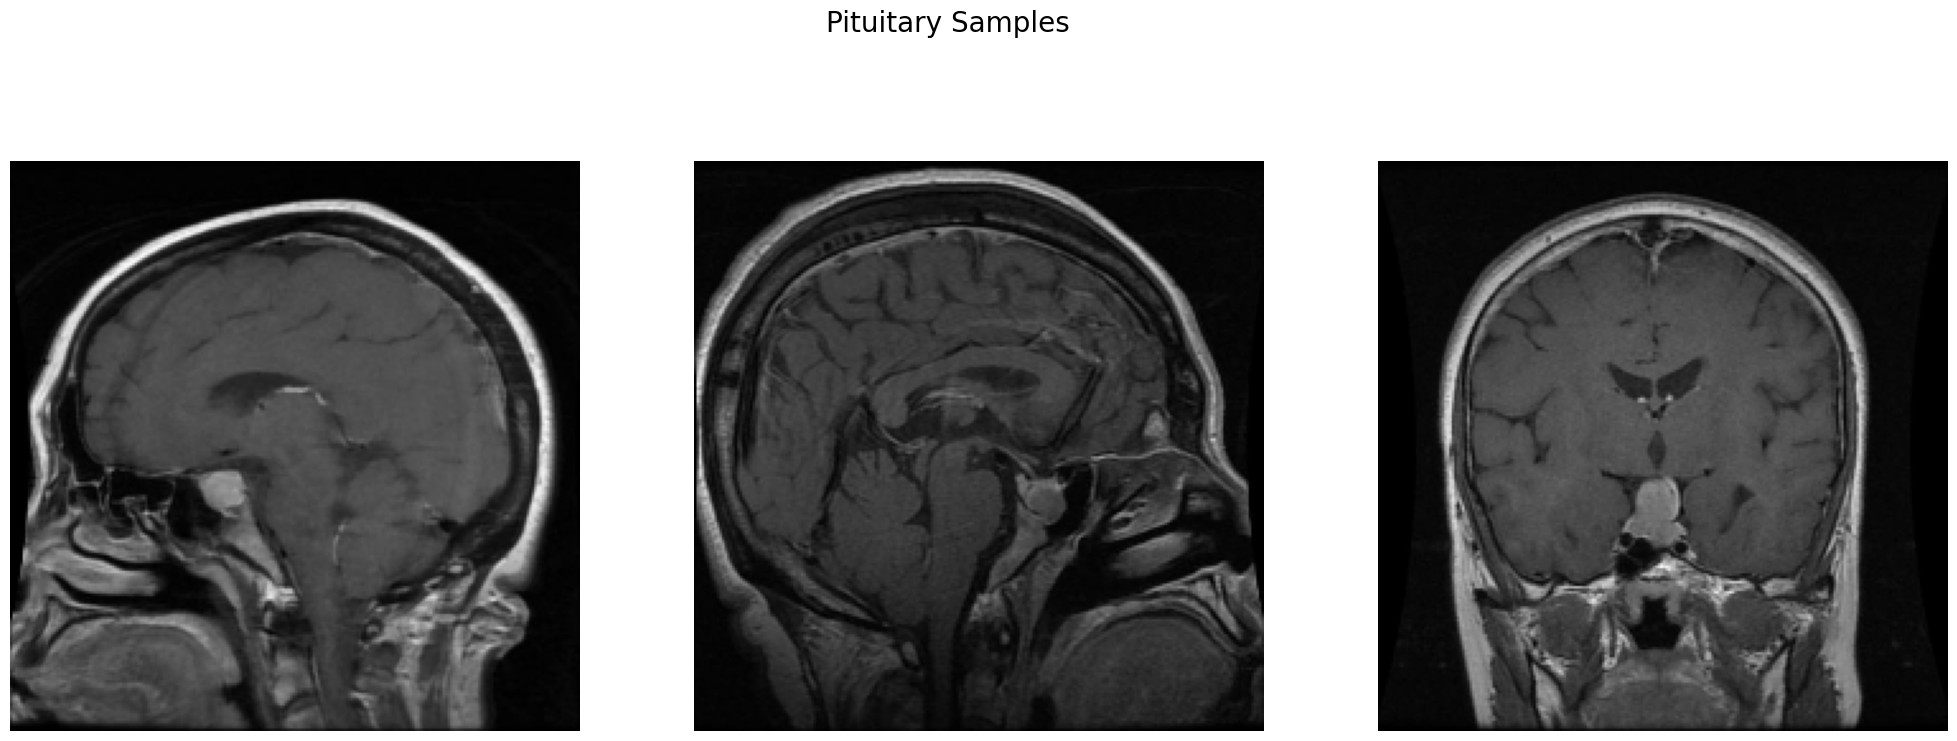

In [36]:
show_samples(PIimages, PITUITARY_DIR, 'Pituitary Samples')

Otsu's optimal threshold value: 37.0


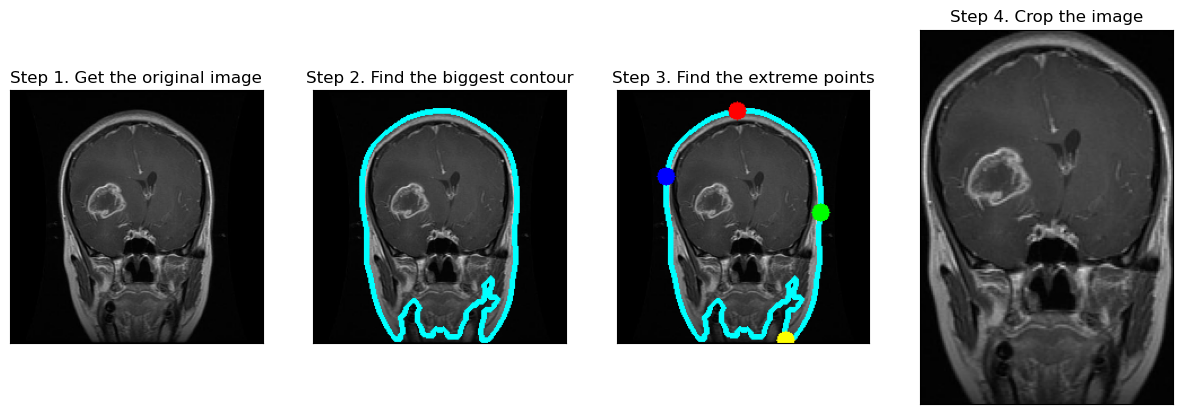

In [ ]:
# Sample of otsu edge detection, The main functionality is available in otsu-edge-detection.ipynb

img = cv2.imread('./data/training/glioma/Tr-glTr_0009.jpg')
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# Otsu's thresholding
thresh_value, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(f"Otsu's optimal threshold value: {thresh_value}")

thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]  # Replace imutils.grab_contours
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [5]:
def load_images(base_path, labels, image_size=200):
    """Load and preprocess images from directory"""
    images, targets = [], []
    
    for label in labels:
        for file in tqdm(os.listdir(os.path.join(base_path, label)), desc=label):
            img = cv2.imread(os.path.join(base_path, label, file), 0)
            img = cv2.bilateralFilter(img, 2, 50, 50)
            img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)
            img = cv2.resize(img, (image_size, image_size))
            images.append(img)
            targets.append(labels.index(label))
    
    return np.array(images) / 255.0, np.array(targets)

BASE_PATH = './data/cropped-otsu'
LABELS = ['glioma', 'meningioma', 'notumor', 'pituitary']
IMAGE_SIZE = 200

# Load data
x_train, y_train = load_images(f'{BASE_PATH}/training', LABELS, IMAGE_SIZE)
x_test, y_test = load_images(f'{BASE_PATH}/testing', LABELS, IMAGE_SIZE)

print(x_train.shape)
print(x_test.shape)

pituitary: 100%|██████████| 300/300 [00:00<00:00, 1206.90it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


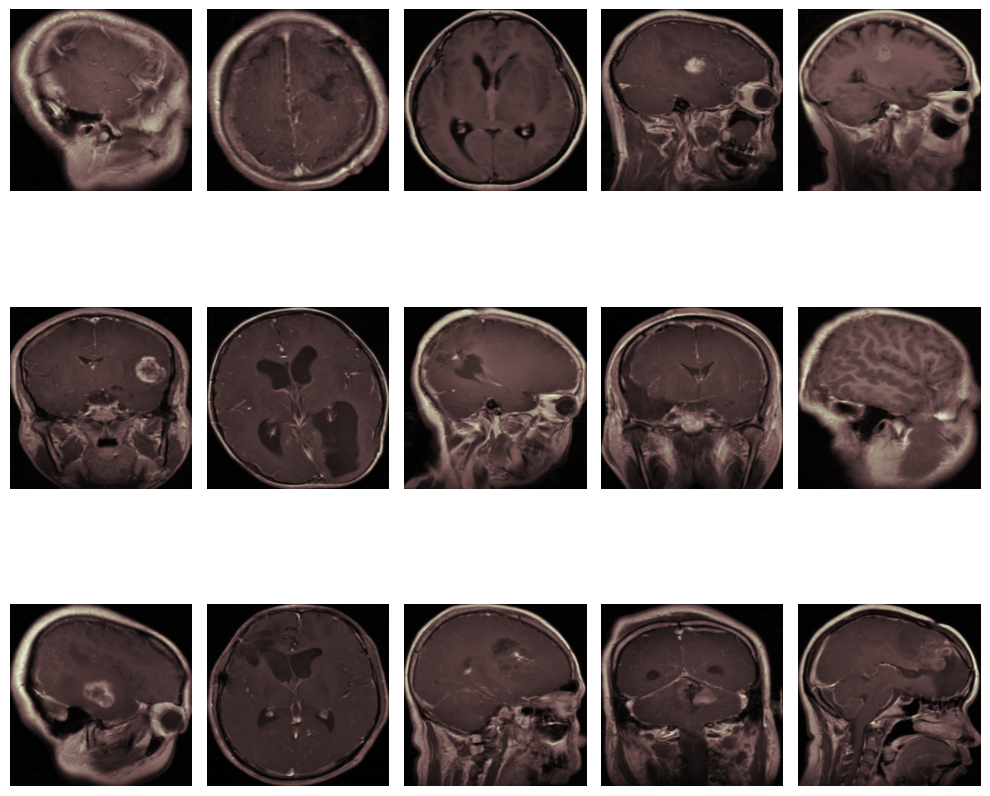

In [6]:
# Simple grid display
fig, axes = plt.subplots(3, 5, figsize=(10, 10))
for ax, img in zip(axes.flatten(), x_train[:15]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Prepare data
x_train, y_train = shuffle(x_train, y_train, random_state=42)
y_train, y_test = to_categorical(y_train), to_categorical(y_test)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Train: {x_train.shape}, Val: {x_val.shape}, Test: {x_test.shape}")

Train: (4569, 200, 200, 3), Val: (1143, 200, 200, 3), Test: (1311, 200, 200, 3)


In [7]:
data_generator = ImageDataGenerator(
    rotation_range = 10,                        
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    zoom_range=0.2,
    shear_range=0.05,
    horizontal_flip = True,
    vertical_flip = True,
)

data_generator.fit(x_train)

In [8]:
IMG_SIZE=(200,200)

conv_base = ResNet50(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

I0000 00:00:1763540930.070694    5229 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6153 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [9]:
def build_model(conv_base):
    x = conv_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(4, activation='softmax')(x)

    return Model(conv_base.input, predictions)

model = build_model(conv_base)

In [10]:
callbacks = [ModelCheckpoint('.mdl_wts.hdf5.keras', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]


In [11]:
model_optimzer = Adam(learning_rate=0.0001)
model.compile(optimizer=model_optimzer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:
BATCH_SIZE = 32
EPOCHS = 50

history = model.fit(
    data_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50


I0000 00:00:1763540957.886378    7299 service.cc:152] XLA service 0x70ecd40020b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763540957.886397    7299 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-19 11:59:18.271791: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763540960.115861    7299 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1763540985.613458    7299 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.7692 - loss: 0.5876

2025-11-19 12:01:09.953536: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1722', 560 bytes spill stores, 560 bytes spill loads

2025-11-19 12:01:10.038376: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1722', 2916 bytes spill stores, 2904 bytes spill loads

2025-11-19 12:01:15.608421: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1722', 580 bytes spill stores, 580 bytes spill loads

2025-11-19 12:01:15.647288: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1722', 748 bytes spill stores, 748 bytes spill loads




Epoch 1: val_loss improved from None to 10.03722, saving model to .mdl_wts.hdf5.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 134s 667ms/step - accuracy: 0.8671 - loss: 0.3573 - val_accuracy: 0.2336 - val_loss: 10.0372 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9401 - loss: 0.1651
Epoch 2: val_loss improved from 10.03722 to 6.71904, saving model to .mdl_wts.hdf5.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 61s 429ms/step - accuracy: 0.9464 - loss: 0.1552 - val_accuracy: 0.2336 - val_loss: 6.7190 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9650 - loss: 0.1107
Epoch 3: val_loss improved from 6.71904 to 2.53016, saving model to .mdl_wts.hdf5.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 61s 429ms/step - accuracy: 0.9665 - loss: 0.1004 - val_accuracy: 0.2336 - val_loss: 2.5302 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9685 - loss: 0.0874
Epoch 4: val_loss improved

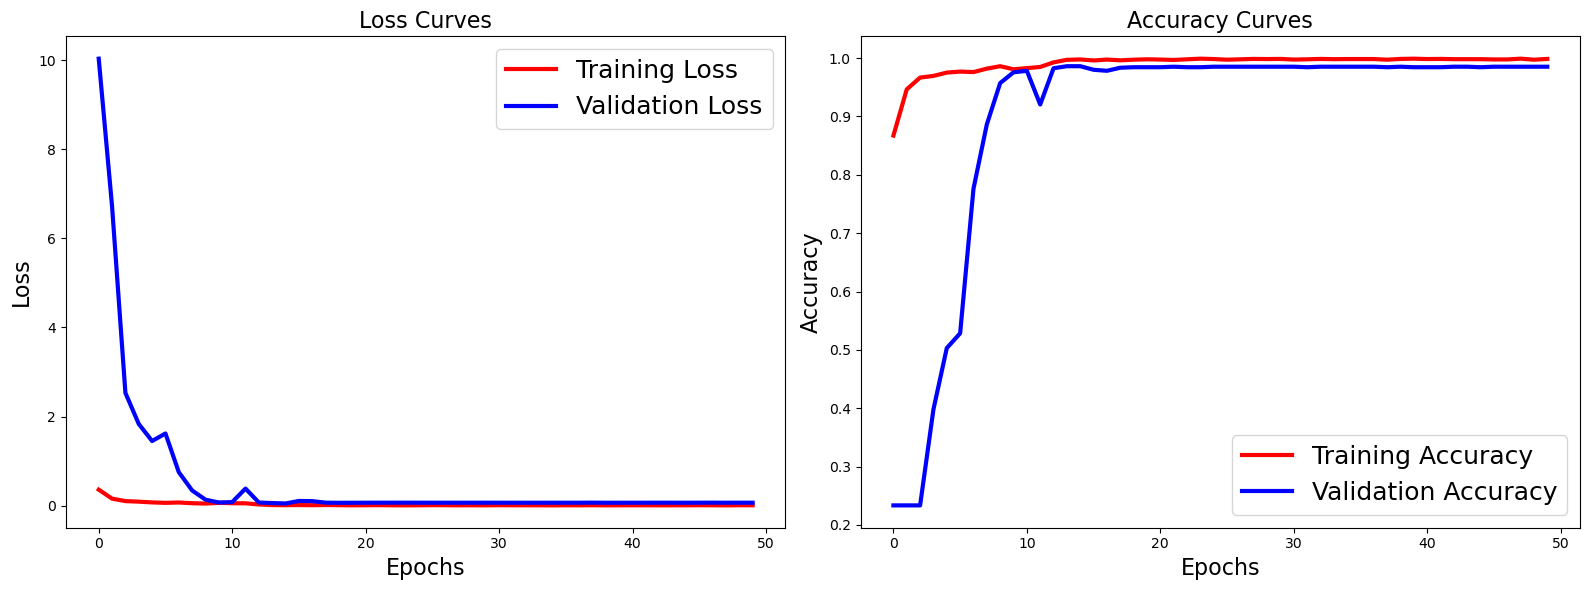

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Loss subplot
ax1.plot(history.history['loss'], 'r', linewidth=3.0, label='Training Loss')
ax1.plot(history.history['val_loss'], 'b', linewidth=3.0, label='Validation Loss')
ax1.set_xlabel('Epochs', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax1.set_title('Loss Curves', fontsize=16)
ax1.legend(fontsize=18)

# Accuracy subplot
ax2.plot(history.history['accuracy'], 'r', linewidth=3.0, label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], 'b', linewidth=3.0, label='Validation Accuracy')
ax2.set_xlabel('Epochs', fontsize=16)
ax2.set_ylabel('Accuracy', fontsize=16)
ax2.set_title('Accuracy Curves', fontsize=16)
ax2.legend(fontsize=18)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
model = load_model('.mdl_wts.hdf5.keras')
model.save('./model_res50.h5.keras')

In [18]:
model = load_model('./model_res50.h5.keras')
accuracy = model.evaluate(x_test, y_test)
print('\n', 'Test_Accuracy:-', accuracy[1])

40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9853 - loss: 0.0342

2025-11-19 13:05:08.530643: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1722', 580 bytes spill stores, 580 bytes spill loads

2025-11-19 13:05:08.571414: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1722', 876 bytes spill stores, 876 bytes spill loads



41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.9916 - loss: 0.0259

 Test_Accuracy:- 0.9916094541549683


In [20]:
BATCH_SIZE = 32
CLASS_NAMES = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

y_pred_classes = np.argmax(model.predict(x_test, batch_size=BATCH_SIZE), axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes, 
                           target_names=CLASS_NAMES, digits=2))

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.98      0.99      0.98       306
    no_tumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step


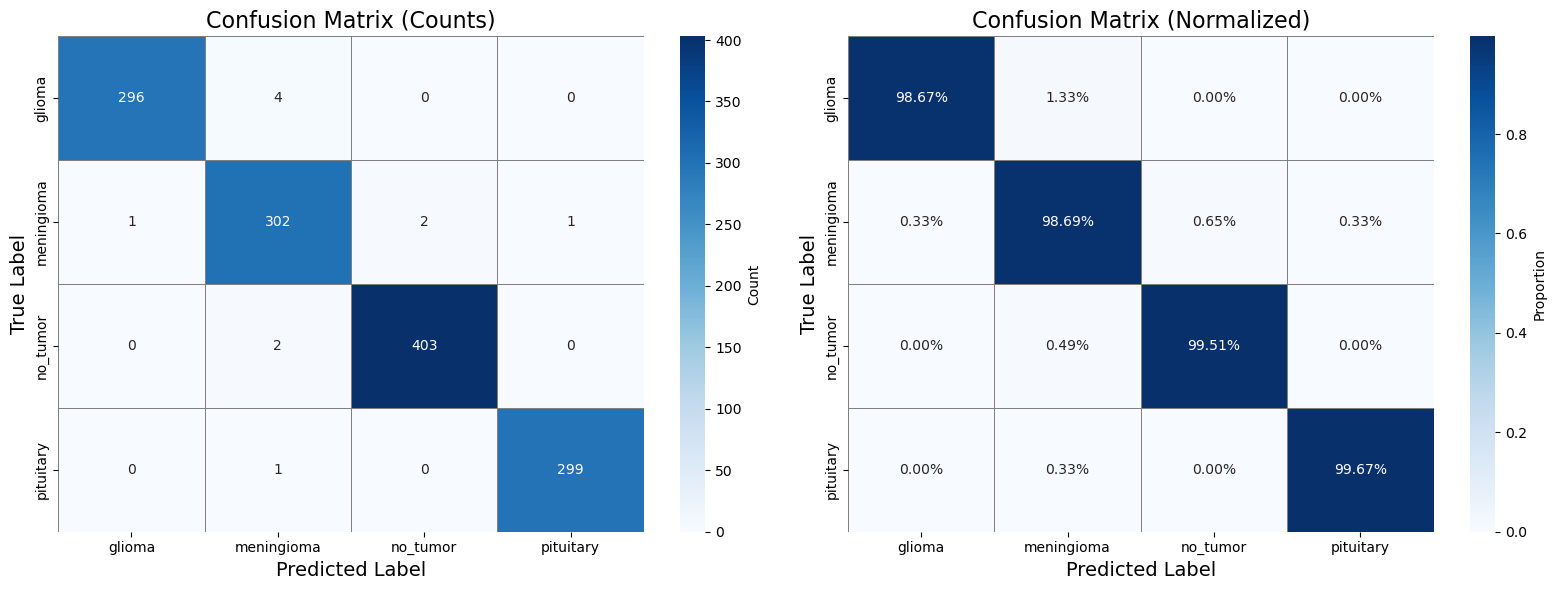

In [23]:
# Predict
pred_Y = model.predict(x_test, batch_size=32, verbose=1)
Y_pred_classes = np.argmax(pred_Y, axis=1)
Y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(Y_true_classes, Y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=class_names, yticklabels=class_names,
            linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix (Counts)', fontsize=16)
ax1.set_ylabel('True Label', fontsize=14)
ax1.set_xlabel('Predicted Label', fontsize=14)

# Normalized (percentage)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax2,
            xticklabels=class_names, yticklabels=class_names,
            linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Proportion'})
ax2.set_title('Confusion Matrix (Normalized)', fontsize=16)
ax2.set_ylabel('True Label', fontsize=14)
ax2.set_xlabel('Predicted Label', fontsize=14)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

2025-11-19 13:18:15.103521: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1677', 560 bytes spill stores, 560 bytes spill loads



81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

2025-11-19 13:18:24.084184: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1677', 8 bytes spill stores, 8 bytes spill loads

2025-11-19 13:18:24.316815: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1677', 572 bytes spill stores, 572 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step


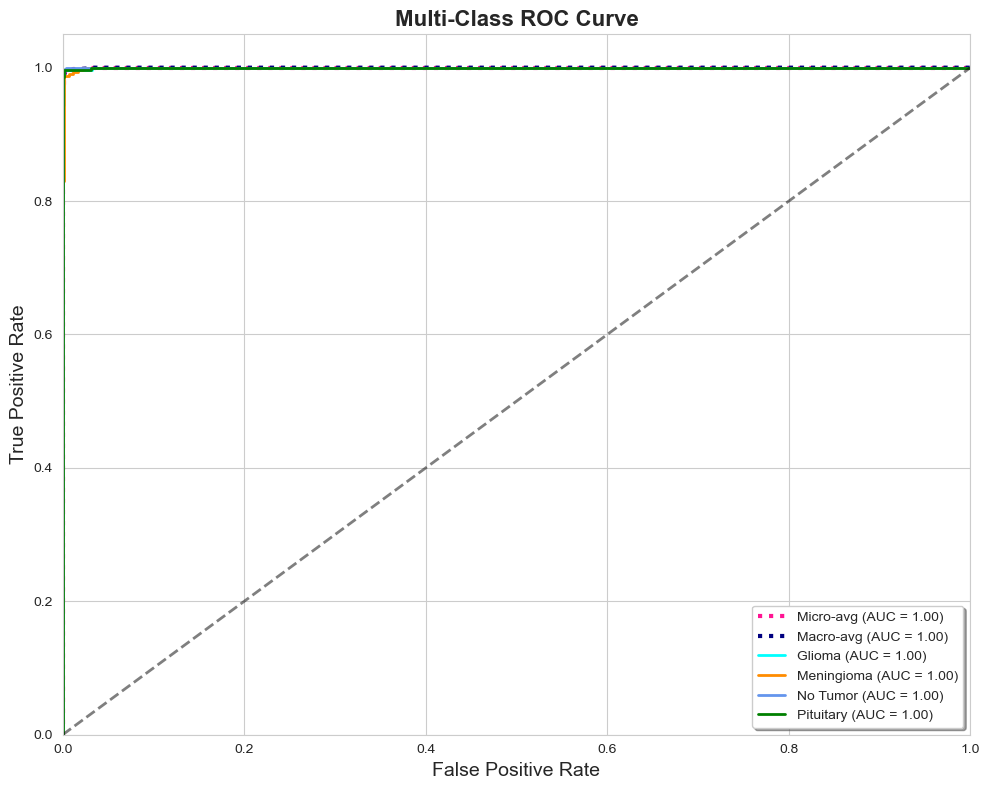

<Figure size 640x480 with 0 Axes>

In [25]:
sns.set_style("whitegrid")

# Predict
pred_Y = model.predict(x_test, batch_size=16, verbose=1)
y_test = np.array(y_test)
n_classes = 4

# Compute ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.mean([np.interp(all_fpr, fpr[i], tpr[i]) for i in range(n_classes)], axis=0)
fpr["macro"], tpr["macro"], roc_auc["macro"] = all_fpr, mean_tpr, auc(all_fpr, mean_tpr)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-avg (AUC = {roc_auc["micro"]:.2f})', 
         color='deeppink', linestyle=':', linewidth=3)
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-avg (AUC = {roc_auc["macro"]:.2f})', 
         color='navy', linestyle=':', linewidth=3)

class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, (color, name) in enumerate(zip(colors, class_names)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-Class ROC Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=10, frameon=True, shadow=True)
plt.tight_layout()
plt.savefig('roc_curve_multiclass.png', dpi=300, bbox_inches='tight')
plt.show()
sns.despine()

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step


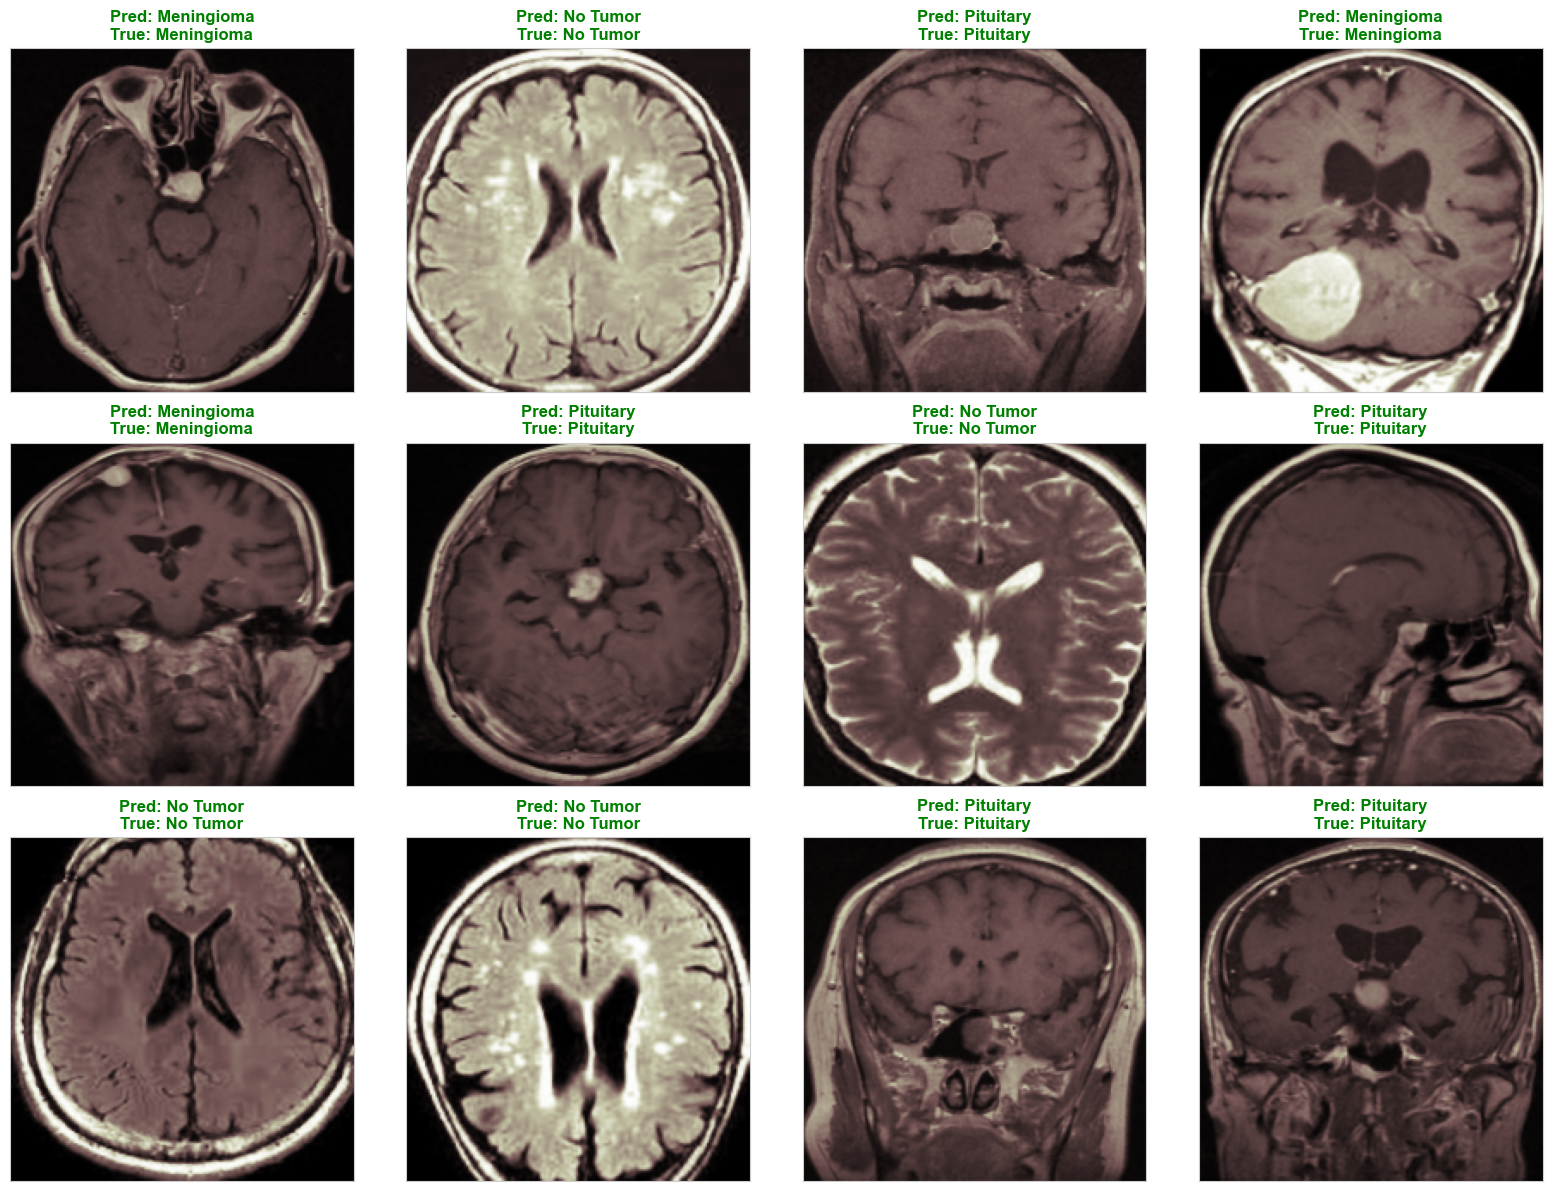

In [26]:
# Predict
y_hat = model.predict(x_test)

# Class labels
target_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Plot random samples
fig = plt.figure(figsize=(16, 12))
random_indices = np.random.choice(x_test.shape[0], size=12, replace=False)

for i, idx in enumerate(random_indices):
    ax = fig.add_subplot(3, 4, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    
    color = "green" if pred_idx == true_idx else "red"
    ax.set_title(f"Pred: {target_labels[pred_idx]}\nTrue: {target_labels[true_idx]}", 
                 color=color, fontsize=12, fontweight='bold')
    
    # Add border for incorrect predictions
    if pred_idx != true_idx:
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(3)

plt.tight_layout()
plt.savefig('prediction_samples.png', dpi=300, bbox_inches='tight')
plt.show()
